# Testing fitting of charged particle multiplicity distributions

## Loading

First we load the Python ROOT interface.  Note, this notebook is set up to use Python 3+.  If you are using Python 2, change the Jupyter kernel and re-run. 

In [1]:
import ROOT as R
from distutils.sysconfig import get_python_inc

Welcome to JupyROOT 6.10/02


Next we add *RooUnfold* to our search path for headers, and load the library. Note, for ROOT 6+ we need the `libUnfold` library

In [2]:
if R.gROOT.GetVersionInt() >= 60000: R.gSystem.Load("libUnfold.so");
R.gSystem.AddIncludePath("-I../roounfold/src");
R.gSystem.Load("../roounfold/libRooUnfold.so");

Now we set-up some stuff for compilation.  

- The variable `suf` is our compilation option
- If we're using ROOT 6+ we need to redefine how to compile shared libraries.  The problem is, that ROOT 6+ Cling adds directories like      `/usr/include/c++/7` to the header search path for the compiler - which it mustn't - so we take out the `$IncludePath` place holder in the library   building string, and put in explicit directories.  There's a [bug report](https://sft.its.cern.ch/jira/browse/ROOT-8991) on this in ROOT Jira   
- Optionally, we can set the debugging level

In [3]:
suf = "+g"; # "" if R.gROOT.GetVersionInt() >= 60000 else "+g";

if R.gROOT.GetVersionInt() >= 60000 :
    incl    = R.TString("-DUSE_PYTHON=1"
                        +" -I"+get_python_inc()
                        +" -I../roounfold/src"
                        +" -I$ROOTSYS/include"
                        +" -I$ROOTSYS/etc"
                        +" -I$ROOTSYS/etc/cling"
                       )
    mkshlib = R.TString(R.gSystem.GetMakeSharedLib())
    mkshlib.ReplaceAll("$IncludePath", incl.Data())
    R.gSystem.SetMakeSharedLib(mkshlib.Data())
    print(R.gSystem.GetMakeSharedLib())
    
R.gSystem.AddIncludePath("-DUSE_PYTHON=1")
R.gSystem.AddIncludePath("-I"+get_python_inc())
R.gDebug = 0 # 7 to show compile commands, 10 to keep intermediate files

cd $BuildDir ; c++ -c $Opt -pipe -m64 -W -Woverloaded-virtual -fsigned-char -fPIC -pthread -std=c++11 -DUSE_PYTHON=1 -I/usr/include/python2.7 -I../roounfold/src -I$ROOTSYS/include -I$ROOTSYS/etc -I$ROOTSYS/etc/cling $SourceFiles ; c++ $ObjectFiles -shared  $LinkedLibs -o $SharedLib


Now we load our base code - these are 
- [SmearModel](SmearModel.C) Basic and concrete smearing models
- [ResponseModel](ResponseModel.C) Basic and concrete detector response models
- [InputModel](InputModel.C) Basic and concrete models of the input data
- [FitModel](FitModel.C) Basic and concrete models for fitting a function to the distributions
- [TestModel](TestModel.C) Base class for tests
- [PyModel](PyModel.C) Python interface classes for defining tests in Python

In [4]:
R.gROOT.LoadMacro("SmearModel.C" + suf)
R.gROOT.LoadMacro("ResponseModel.C" + suf)
R.gROOT.LoadMacro("InputModel.C" + suf)
R.gROOT.LoadMacro("FitModel.C"+suf)
R.gROOT.LoadMacro("TestModel.C" + suf) 
R.gROOT.LoadMacro("PyModel.C" + suf);

## A simple test

In this test we use 

- a negative binomial distribution for the input ("truth") distribution, defined as 
  $$P(n;k,m)=\frac{\Gamma(n+k)}{\Gamma(k)\Gamma(n+1)}\left(\frac{m}{m+k}\right)^n\left(\frac{k}{m+k}\right)^k$$
  where $m=k(1-p)$ is the mean of the distribution (Class `NBD`)

- A parameterized (non-linear) detector response (Class `ParamResponse`)

- Gaussian smearing perpendicular to the response function local slope (Class `GaussianPerpSmear`)

- The generated response matrix is flat in the input distribution.

We can now load our simple test. 

In [5]:
R.gROOT.LoadMacro("SimpleTest.C"+suf);

We define an object of our test type and define a canvas to draw in.

In [6]:
# R.SimpleTest()
simpleTest = R.SimpleTest();
simpleCanvas = R.TCanvas("simple","simple",1200,1200);

and then run our test

In [7]:
flat = True; # Change to False for a non-flat training sample
simpleTest.Run("",flat,0,True,True,True,1000000,simpleCanvas);

Running the test
Fitting range set to   1 -  57
Which       | chi^2/nu    | A                 | p                 | k                 
pdf         |    0.000000 |  1.0000+/- 0.0000 |  0.6000+/- 0.0000 | 30.0000+/- 0.0000 
straightFit |    8.008442 |  1.0000+/- 0.0000 |  0.6326+/- 0.0014 | 34.2560+/- 0.2024 
outputFit   |  223.821155 |  1.0000+/- 0.0000 |  0.6128+/- 0.0008 | 31.4946+/- 0.1063 
unfoldedFit |    3.934568 |  1.0000+/- 0.0000 |  0.6124+/- 0.0010 | 31.5420+/- 0.1266 
statFit     |  120.809401 |  1.0000+/- 0.0000 |  0.6414+/- 0.0005 | 35.8830+/- 0.0812 


In the output above, the line marked `pdf` shows the input parameters - that is $p=0.6$ and $k=30$.  The lines below that show the result of fitting a negative binomial distribution to the unfolded distribution $U$. 

- `straightFit` is using the default fitting algorithm of ROOT to fit $P$ to $U$. 
- `outputFit` fits the response folded distribution ($R\circ P$) to the output (measured) distribution $O$ via a modified $\chi^2$ function.
- `unfoldedFit` fits the distribution $P$ to the unfolded distribution $U$, but folds the statistical errors of the measured distribution $O$ via the response matrix $R$ via a modified $\chi^2$ function.
- `statFit` fits the distribution $P$ to the unfolded distribution, using default ROOT fitting, but with statistical errors calculated via the response matrix $R$. 

Clearly, the `straightFit` and `outputFit` strategies are not very good.  Not only do they give large reduced $\chi^2$ values, but the parameters are generally not as well determined as in the other cases.  The `statFit` strategy has a slight edge over the `unfoldedFit` strategy. 

Now lets draw the result in a canvas.

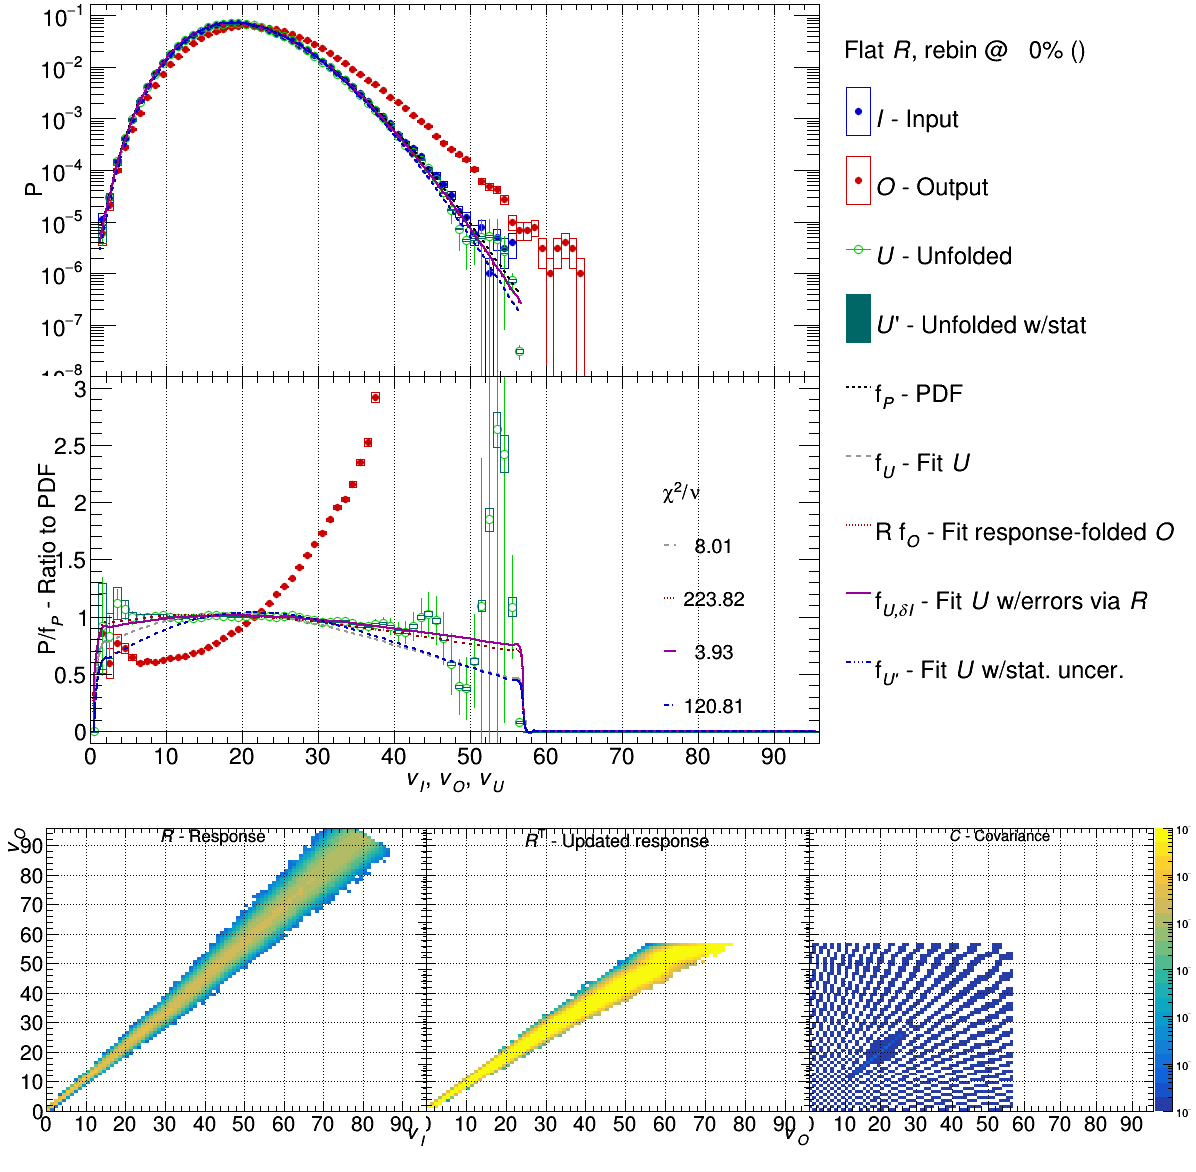

In [8]:
simpleCanvas.Draw();

Lets run the same test, but with a non-flat response matrix

Running the test
Fitting range set to   1 -  52
Which       | chi^2/nu    | A                 | p                 | k                 
pdf         |    0.000000 |  1.0000+/- 0.0000 |  0.6000+/- 0.0000 | 30.0000+/- 0.0000 
straightFit |    0.144671 |  1.0000+/- 0.0000 |  0.5951+/- 0.0018 | 29.3923+/- 0.2160 
outputFit   |  303.040793 |  1.0000+/- 0.0000 |  0.6313+/- 0.0008 | 33.9617+/- 0.1163 
unfoldedFit |    0.340482 |  1.0000+/- 0.0000 |  0.5949+/- 0.0010 | 29.3599+/- 0.1167 
statFit     |    0.768464 |  1.0000+/- 0.0000 |  0.5947+/- 0.0008 | 29.3307+/- 0.0991 


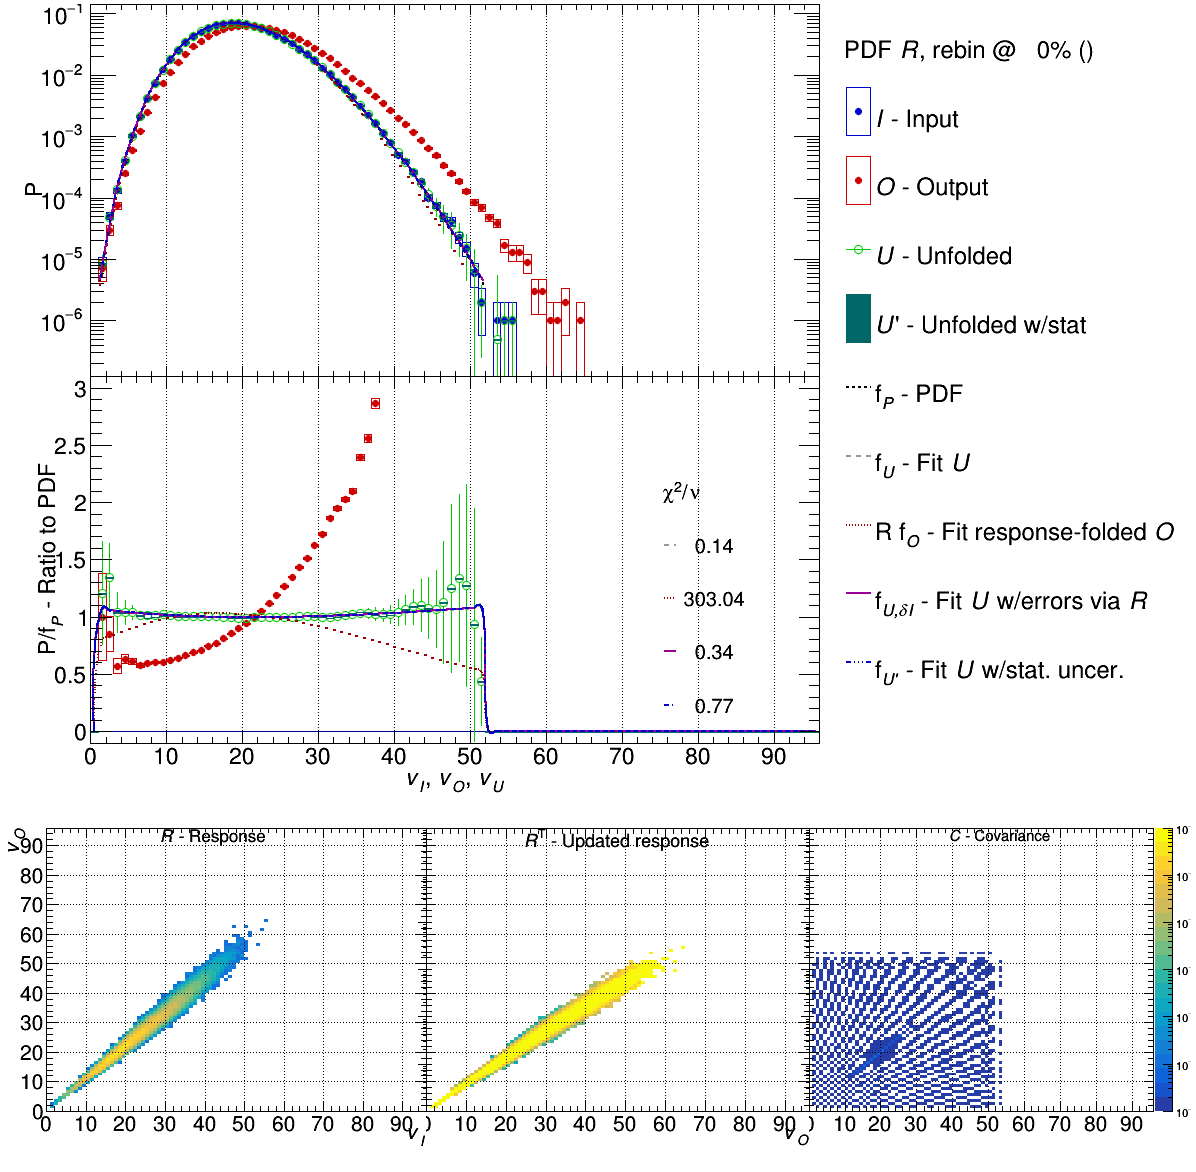

In [9]:
simpleCanvasAgain = R.TCanvas("simpleAgain","simple",1200,1200);
flat = False; # Change to False for a non-flat training sample
simpleTest.Run("",flat,0,True,True,True,1000000,simpleCanvasAgain);
simpleCanvasAgain.Draw();

The `outputFit` strategy is still doing significantly worse than the other strategies.  However, now, the `straightFit` strategy gives the best reduced $\chi^2$ value (albeit close to the other two strategies) and relatively well-determined parameter values.  The point of this is, that even with a non-flat response matrix we get a well determined unfolded distribution $U$. 

## A more complicated test

In this test we use 

- a double negative binomial distribution for the input ("truth") distribution, defined as 
  $$P(n;\alpha,k_1,m_1,k_2,m_2)=\alpha P(n;k_1,m_1)+(1-\alpha)P(n;k_2,m_2)$$
  where $m_1=k_1(1-p_1)$ and $m_2=k_2(1-p_2)$ are the means of the distributions (Class `DoubleNBD`)

- A parameterized (non-linear) detector response (Class `ParamResponse`)

- Gaussian smearing perpendicular to the response function local slope (Class `GaussianPerpSmear`)

- A non-flat (distributed according the input PDF) respone matrix

Lets load the code 

In [10]:
R.gROOT.LoadMacro("DoubleTest.C" + suf);

We create an instance of our test and run it. 

In [11]:
flat = False; # Change to True for a flat response matrix
doubleCanvas = R.TCanvas("double","double",1200,1200);
doubleTest = R.DoubleTest();
doubleTest.Run("double",flat,0.,True,True,True,100000,doubleCanvas)

Running the test
Fitting range set to   1 -  79
Which       | chi^2/nu    | A                 | #alpha            | p_{1}             | k_{1}             | p_{2}             | k_{2}             
pdf         |    0.000000 |  1.0000+/- 0.0000 |  0.6000+/- 0.0000 |  0.6000+/- 0.0000 | 30.0000+/- 0.0000 |  0.5000+/- 0.0000 | 40.0000+/- 0.0000 
straightFit |    0.023599 |  1.0002+/- 0.0075 |  0.5994+/- 0.0097 |  0.6006+/- 0.0172 | 29.9957+/- 1.9682 |  0.4894+/- 0.0183 | 38.3084+/- 3.0140 
outputFit   |    1.936370 |  0.8702+/- 0.0028 |  0.6389+/- 0.0039 |  0.5981+/- 0.0074 | 29.9600+/- 0.8530 |  0.5464+/- 0.0087 | 48.3534+/- 1.8046 
unfoldedFit |    0.165089 |  0.9997+/- 0.0034 |  0.6003+/- 0.0046 |  0.6013+/- 0.0083 | 30.1103+/- 0.9616 |  0.4931+/- 0.0086 | 38.8992+/- 1.4374 
statFit     |    0.222242 |  0.9999+/- 0.0034 |  0.6013+/- 0.0044 |  0.5999+/- 0.0105 | 29.9505+/- 1.2467 |  0.4951+/- 0.0064 | 39.2398+/- 1.1141 


The meaning of the rows is the same as above. 

Lets draw the result

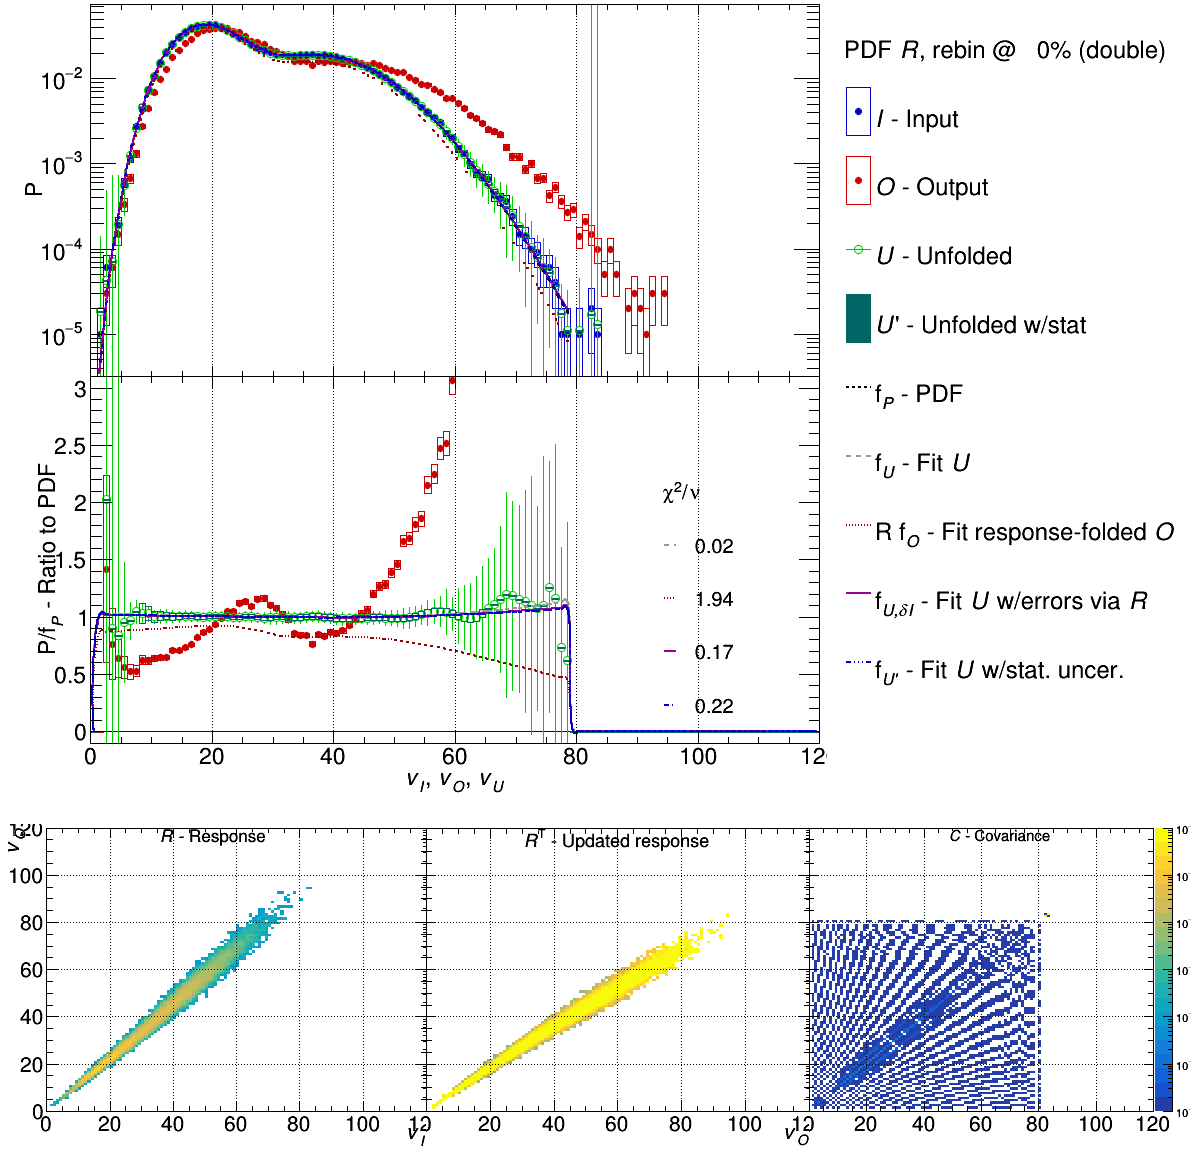

In [12]:
doubleCanvas.Draw();

The `outputFit` strategy is still doing pretty bad.  The reduced $\chi^2$ is reasonable, but the parameter values are way off. The other three strategies gives reasonable results, with a small preference for the `unfoldedFit` and `statFit` strategies. 

## Defining new tests in Python

Here, we show how to define some new tests in the Jupyter notebook.  First, let's define a new smearing model.  This will simply add some uniform random noise.

In [13]:
class MySmear(R.PySmearModel):
    """Smearing mode"""
    def __init__(self):
        """Constructor"""
        R.PySmearModel.__init__(self,self)
    def Smear(self,output, inp, slope):
        """Smear the input value
        
        :param output: Output value after response
        :param input: Input value before response
        :param slope: Local slope of response 
        
        :returns: output plus random noise, and possibly input smeared 
        :rtype: double or [double,double]
        """
        ret = output * (1 + R.gRandom.Uniform(0,.1))
        return [ret,inp]
        # return ret

Next, we define an input model.  This will simply draw numbers from an Poisson distribution

In [14]:
class MyInput(R.PyInputModel):
    """An input model
    
    This will draw random number from an exponential distribution
    """
    def __init__(self,maxN=30):
        """Constructor
        
        :param maxN: Largest possible value of N
        """
        R.PyInputModel.__init__(self,self)
        self.pdf = R.TF1("pdf","[0]*TMath::PoissonI(x,[1])",0,maxN)
        self.pdf.SetParameters(1,maxN/3.)
        self.pdf.SetParNames("A", "mean")
    def Sample(self):
        """Sample the PDF
        
        :returns: A random number drawn from the defined PDF
        :rtype: double
        """
        ret = self.pdf.GetRandom()
        # print(ret)
        return ret
    def Func(self):
        """Get reference to PDF function
        
        :return: Reference to the PDF function object
        :rtype: ROOT.TF1
        """
        return self.pdf
    def NewFunc(self,name):
        """Get a copy of the PDF
        
        :param name: Name of function
        :return: A new copy of the PDF function object
        :rtype: ROOT.TF1
        """
        r = R.TF1(name,"[0]*TMath::PoissonI(x,[1])",0,self.pdf.GetXmax())
        r.SetParameters(self.pdf.GetParameters())
        r.SetParNames("A", "mean")
        return r;

Let's also define a simple fitter - just to try it out

In [15]:
class MyFit(R.PyFitModel):
    def __init__(self):
        """Constructor"""
        R.PyFitModel.__init__(self,self)
    def GetName(self):
        """Get name of the object 
        
        :return: Name to use for the function object
        :rtype: str
        """
        return "myFit"
    def GetTitle(self):
        """Get title of the object 
        
        :return: Title to use for the function in legends
        :rtype: str
        """
        return "#it{f}_{mine}"
    def GetColor(self):
        """Get colour of the object 
        
        :return: Colour to use the function object
        :rtype: int
        """
        return R.kPink+1
    def GetStyle(self):
        """Get line style of the object 
        
        :return: Line style to use the function object
        :rtype: int
        """
        return 3
    def Fit(self,f,output,unfolded,response,update,min,max):
        unfolded.Fit(f,"QOR","",min,max)
        self.SetResult(f)
        f.Print()
        return 1

The final thing to define is a response model. 

In [16]:
class MyResponse(R.PyResponseModel):
    """A model for the response"""
    def __init__(self,smear=None):
        """Constructor"""
        R.PyResponseModel.__init__(self,self)
        self.smear = smear
    def ToOutput(self,inp):
        """Find output - linear Response
        
        :param inp: Input value
        :return: The output value corresponding to inp, and possibly inp smeared too (depends on smearing model)
        :rtype: double or [double,double]
        """
        out = .9 * inp;
        if self.smear is None: 
            return out
        ret = self.smear.Smear(out, inp, 1)
        return ret

Now we can put all these things together into a simple test.  This test will have 

- Poisson distribution of number of particles
- A linear response 
- Uniform smearing

In [17]:
class MyTest(R.PyTestModel):
    """An example of creating a test in Python"""
    def __init__(self):
        """Constructor"""
        R.PyTestModel.__init__(self,self)
        self.input     = MyInput();
        self.smear     = MySmear()
        self.response  = MyResponse(self.smear)
        self.normalFit = R.NormalFit();
        self.unfoldFit = R.UnfoldFit();
        self.myFit     = MyFit()
    def GetInputModel(self):
        """Get the input model
        
        :return: The input model used
        :rtype: ROOT.InputModel 
        """
        # print("Calling python GetInputModel")
        return self.input
    def GetResponseModel(self):
        """Get the response model
        
        :return: The response model used
        :rtype: ROOT.SmearModel
        """
        # print("Calling Python GetResponseModel")
        return self.response 
    def GetNFitModels(self):
        """Get the number of fit models 
        
        :return: Number objectf defined fit models
        :rtype: integer
        """
        return 3;
    def GetFitModel(self,no):
        """Get a fit model
        
        :param no: Fit model number
        :return: The fit model
        :rtype: R.FitModel
        """
        return {
            0: self.normalFit,
            1: self.unfoldFit,
            2: self.myFit,
        }[no]

Now, let's run our test

Running the test
Fitting range set to   0 -  28
Formula based function:     myFit 
                myFit : [0]*TMath::PoissonI(x,[1]) Ndim= 1, Npar= 2, Number= 0 
 Formula expression: 
	[A]*TMath::PoissonI(x,[mean]) 
Which       | chi^2/nu    | A                 | mean              
pdf         |    0.000000 |  1.0000+/- 0.0000 | 10.0000+/- 0.0000 
straightFit |    0.098378 |  0.9987+/- 0.0056 | 10.0067+/- 0.0210 
unfoldedFit |    0.497734 |  0.9999+/- 0.0031 | 10.0035+/- 0.0102 
myFit       |    0.098378 |  0.9987+/- 0.0056 | 10.0067+/- 0.0210 


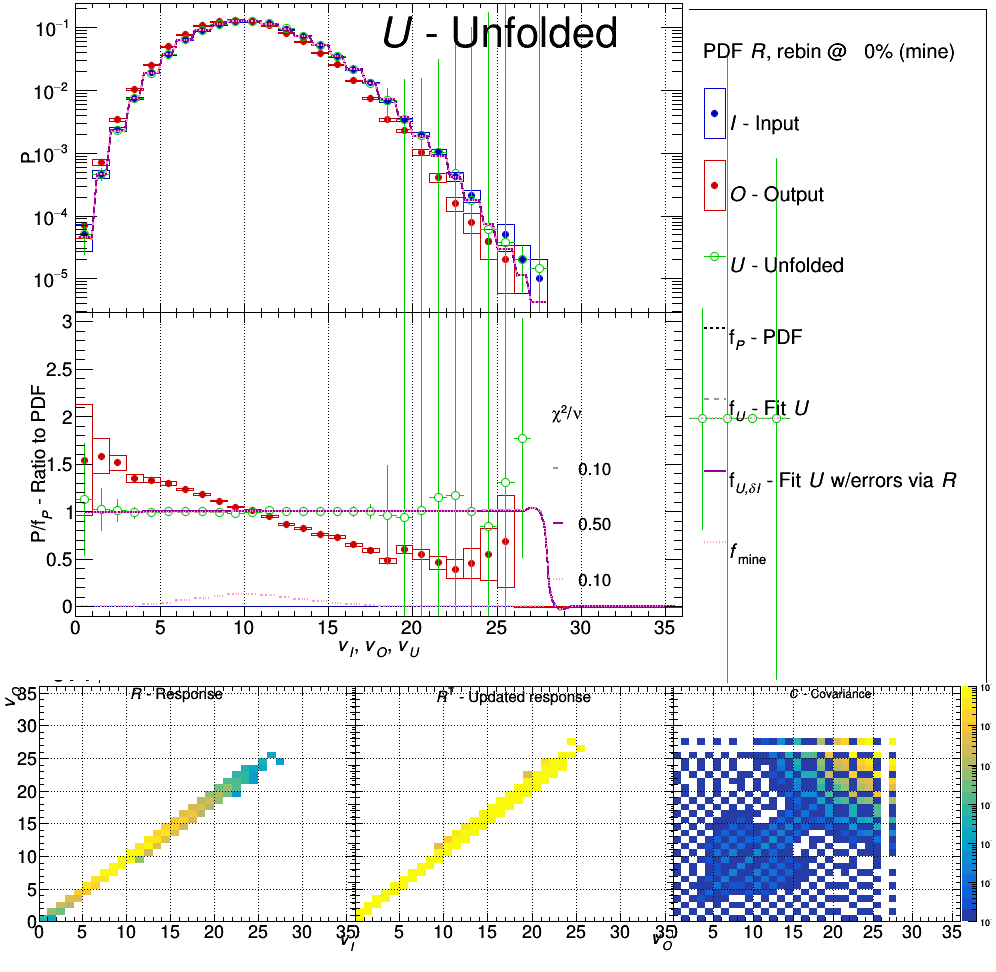

In [18]:
myCanvas = R.TCanvas("myCanvas", "myCanvas", 1000, 1000)
myTest = MyTest()
flat = False
myTest.Run("mine",flat,0.,True,True,True,100000,myCanvas)
myCanvas.Draw()

Not unsurprising, we find that the last two fitting strategies work best again. 

Let's do a test with a flat input distribution

In [19]:
# --- Flat input model ---------------------------------------------
class FlatInput(R.PyInputModel):
    """An input model
    
    This will draw random number from flat distribution
    """
    def __init__(self,maxN=50):
        """Constructor
        
        :param maxN: Largest possible value of N
        """
        R.PyInputModel.__init__(self,self)
        self.pdf = R.TF1("pdf","[0]",0,maxN)
        self.pdf.SetParameter(0,1./maxN)
    def Sample(self):
        """Sample the PDF
        
        :return: Random number
        :rtype: double
        """
        ret = self.pdf.GetRandom()
        # print(ret)
        return ret
    def Func(self):
        """Get reference to PDF function 
        
        :return: PDF function object
        :rtype: ROOT.TF1
        """
        return self.pdf
    def NewFunc(self,name):
        """Get a copy of the PDF
        
        :param name: Name of function
        :return: New copy of PDF function object
        :rtype: ROOT.TF1
        """
        r = R.TF1(name,"[0]",0,self.pdf.GetXmax())
        r.SetParameter(0,self.pdf.GetParameter(0))
        return r
# --- Flat test -------------------------------------------------------
class FlatTest(R.PyTestModel):
    """An example of creating a test in Python"""
    def __init__(self):
        """Constructor"""
        R.PyTestModel.__init__(self,self)
        self.input     = FlatInput();
        self.smear     = MySmear()
        self.response  = MyResponse(self.smear)
        self.normalFit = R.NormalFit()
        self.unfoldFit = R.UnfoldFit()
        self.myFit     = MyFit()
    def GetInputModel(self):
        """Get the input model
         
        :return: The input model used
        :rtype: ROOT.InputModel 
       """
        # print("Calling python GetInputModel")
        return self.input
    def GetResponseModel(self):
        """Get the response model
        
        :return: The response model used
        :rtype: ROOT.ResponseModel 
        """
        # print("Calling Python GetResponseModel")
        return self.response 
    def GetNFitModels(self):
        """Get the number of fit models 
        
        :return: Number objectf defined fit models
        :rtype: integer
        """
        return 3;
    def GetFitModel(self,no):
        """Get a fit model
        
        :param no: Fit model number
        :return: The fit model
        :rtype: R.FitModel
        """
        return {
            0: self.normalFit,
            1: self.unfoldFit,
            2: self.myFit,
        }[no]    
# --- Run test -------------------------------------------------------
flatCanvas = R.TCanvas("flatCanvas", "flatCanvas", 1000, 1000)
flatTest = FlatTest()
flat = False
flatTest.Run("mine",flat,0.,True,True,True,100000,flatCanvas)

Running the test
Fitting range set to   0 -  50
Formula based function:     myFit 
                myFit : [0] Ndim= 1, Npar= 1, Number= 0 
 Formula expression: 
	[p0] 
Which       | chi^2/nu    | p0                
pdf         |    0.000000 |  0.0200+/- 0.0000 
straightFit |    0.277909 |  0.0201+/- 0.0001 
unfoldedFit |    2.237876 |  0.0200+/- 0.0001 
myFit       |    0.277909 |  0.0201+/- 0.0001 


We need to modify the scale to be linear for this test

In [20]:
flatCanvas.GetPad(1).GetPad(1).GetPad(1).SetLogy(False)
flatCanvas.Draw()

Again, the 2 last strategies fairs best.  One can continue with these kinds of test - say with a linear  input distribution, more fancy smearings, or highly non-linear response. 